# Neighbor regularization

Test implementation of cKDTree and other methods to compute the difference between a point and its nearest neighbors.

In [1]:
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr
import re
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def read_file(file_path):
    with open(file_path, 'r') as f:
        data = []
        for n,line in enumerate(f,1):
            if n==1:
                line = line.strip()
                line = re.findall(r'"[^"]*"', line) # get ['"var_name1"', '"var_name2"', ...]
                column_labels = [var_name.replace('"','') for var_name in line]
            elif n==2:
                continue
            else:
                data_line = [eval(data) for data in line.split()]
                if len(data_line)==4:
                    break
                data.append(data_line)
    return pd.DataFrame(data, columns=column_labels)

In [3]:
file = Path('/Users/jarl/2d-discharge-nn/data/avg_data/200Vpp_100Pa_node.dat')

In [4]:
df = read_file(file)[['X', 'Y', 'potential (V)']]
df.head()

,X,Y,potential (V)
0,0.182960,0.259570,17.4177
1,0.172908,0.266347,27.8613
2,0.173172,0.254322,18.8931
3,0.176840,0.246447,11.5936
4,0.170305,0.246504,13.0860


In [5]:
X = df.X.to_numpy()  # units: m
Y = df.Y.to_numpy()

## cKDTree test

Create a cKDTree given the list of points `X` and `Y`. 

`query` queries the kd-tree for the nearest neighbors. [Link to documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html#scipy.spatial.cKDTree.query). 

`np.c` combines `X` and `Y` as columns. 

In [6]:
tree = cKDTree(np.c_[X,Y])

Test usage with tensors using dummy data:

In [7]:
# x, y, v, p
x = np.linspace(0, 20, 4)
y = np.linspace(0, 70, 9)
xx, yy = np.meshgrid(x, y)
v = 300.0
p = 60.0

In [8]:
# feature columns
features = pd.DataFrame({'x':xx.reshape(-1), 'y':yy.reshape(-1)})
features['v'] = v
features['p'] = p
# features['x**2'] = features['x']**2
# features['y**2'] = features['y']**2

features.head()

,x,y,v,p
0,0.000000,0.00,300.0,60.0
1,6.666667,0.00,300.0,60.0
2,13.333333,0.00,300.0,60.0
3,20.000000,0.00,300.0,60.0
4,0.000000,8.75,300.0,60.0


In [9]:
tree = cKDTree(np.c_[features['x'], features['y']])

In [10]:
# label columns
labels = pd.DataFrame(np.random.rand(len(features), 5), columns=['potential', 'ne', 'ni', 'nm', 'te'])
labels.head()

,potential,ne,ni,nm,te
0,0.538170,0.821118,0.552084,0.036501,0.947179
1,0.089022,0.658547,0.026206,0.395313,0.109015
2,0.076519,0.683771,0.260041,0.494526,0.723365
3,0.780882,0.695819,0.980196,0.342674,0.143881
4,0.369014,0.249613,0.899937,0.255667,0.769216


In [11]:
data = tf.data.Dataset.from_tensor_slices((features, labels)).batch(3)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-08 15:31:42.045190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-08 15:31:42.045477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
def reg_coefficient(epoch, c=0.3, r=25, which='exp'):
    """Calclulate regularization coefficient.

    Args:
        epoch (int): Current epoch.
        c (float, optional): Regularization coefficient to be approached. Defaults to 0.3.
        r (int, optional): Rate of increase. Coefficient increases by {} over r epochs. Defaults to 25.

    Returns:
        c: 
    """

    if which=='exp':
        return c - c*np.exp(-epoch/r)
    elif which=='sigmoid':
        k = 0.085
        x_0 = 100
        return c/(1 + np.exp(-k*(x-x_0)))
    

### Making predictions on neighbors:

For an input point to the model $\vec{x}$, the difference between the prediction on $\vec{x}$, $f(\vec{x})$, and its $k$ neighbors $\sum_{j=0}^k f(\vec{x_j})$ is added to the training loss. This neighbor loss is parametrized by a coefficient $\lambda$:

$MSE_{neighbor} = \lambda \cdot (f(\vec{x}) - \frac{1}{k}\sum_{j=0}^k f(\vec{x_j}))^2$


The model loss function is thus:

$MSE = MSE_{train} + MSE_{neighbor}$,

where $MSE_{train} = \sum_{i=1}^{N}(\vec{y} - f(\vec{x}))^2 $ for batch size of $N$, and $MSE_{neighbor}$ is a regularization term.

A kd-tree is created to compute the nearest neighbor of any point passed to `tree.query()`. Input vectors of the neighbors are constructed from the kd tree, on which model predictions are made.

The above loop computes the MSE for each entry in each batch (size=3) of the dataset. 

`y_batch_train` is the label, and `batch_mean` is the (mean) model's prediction on `k` neighbors.

In [13]:
from tensorflow import keras

input = keras.Input(shape=(len(features.columns),) )
hidden = keras.layers.Dense(10, activation=tf.nn.sigmoid)(input)
output = keras.layers.Dense(len(labels.columns))(hidden)

model = keras.Model(input, output)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [15]:
k = 3
for (x_batch_train, y_batch_train) in data:
    y_pred = model(x_batch_train)
    for i, point in enumerate(x_batch_train):
        x, y, v, p = point  # unpack point, returns tensors
        v = np.array([v.numpy()])  # convert tensor to 1D vector (numpy)
        p = np.array([p.numpy()])

        _, ii = tree.query([x, y], k=k)  # get nearest k neighbors of point (x,y)
        
        # get pair of x, y of all neighbors
        neighbor_xy = [features[['x', 'y']].iloc[i].to_numpy() for i in ii]

        # combine (x,y) with v and p, as input to the model
        neighbors = [np.concatenate((xy, v, p)) for xy in neighbor_xy]

        # convert to tensor
        neighbors = [tf.expand_dims(tf.convert_to_tensor(neighbor), axis=0) for neighbor in neighbors]
        
        # get mean of neighbor predictions for 5 variables
        neighbors_mean = tf.reduce_mean([model(neighbor) for neighbor in neighbors], axis=1)

    batch_mean = tf.stack(neighbors_mean)
    print(0.3*tf.losses.mean_squared_error(batch_mean, y_pred))

    

tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([1.06581415e-16 0.00000000e+00 1.06581415e-16], shape=(3,), dtype=float32)
tf.Tensor([3.80495670e-14 2.03410639e-13 1.06581415e-16], shape=(3,), dtype=float32)
tf.Tensor([2.5259796e-13 2.5986362e-11 2.2472958e-11], shape=(3,), dtype=float32)
tf.Tensor([2.3173433e-08 1.8347489e-10 2.1655664e-08], shape=(3,), dtype=float32)
tf.Tensor([7.836504e-08 0.000000e+00 7.175916e-08], shape=(3,), dtype=float32)
tf.Tensor([2.2034108e-05 4.5621324e-05 1.8196924e-07], shape=(3,), dtype=float32)
tf.Tensor([9.299000e-05 9.613717e-03 8.106123e-03], shape=(3,), dtype=float32)
tf.Tensor([0.08702703 0.02127535 0.04674514], shape=(3,), dtype=float32)
tf.Tensor([0.03480775 0.         0.00373001], shape=(3,), dtype=float32)


In [16]:
model(x_batch_train)

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[-0.14680845,  0.43788502,  0.27355024, -0.46338657,  1.2706708 ],
       [ 0.11898616,  0.6549394 ,  0.57883495, -0.82287323,  1.2490851 ],
       [ 0.24198163,  0.68312585,  0.67745805, -0.8928988 ,  1.1250478 ]],
      dtype=float32)>

In [17]:
y_batch_train, batch_mean

(<tf.Tensor: shape=(3, 5), dtype=float64, numpy=
 array([[0.69056276, 0.7278134 , 0.75546149, 0.73579398, 0.29365575],
        [0.583312  , 0.75767975, 0.48591242, 0.41140147, 0.59111771],
        [0.01425334, 0.58605492, 0.25851862, 0.17597863, 0.27514167]])>,
 <tf.Tensor: shape=(3, 5), dtype=float32, numpy=
 array([[ 0.24198163,  0.68312585,  0.67745805, -0.8928988 ,  1.1250478 ],
        [ 0.11898616,  0.6549394 ,  0.57883495, -0.82287323,  1.2490851 ],
        [ 0.08355176,  0.6837568 ,  0.5584631 , -0.8632456 ,  1.2734637 ]],
       dtype=float32)>)

In [18]:
y_pred

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[-0.14680845,  0.43788502,  0.27355024, -0.46338657,  1.2706708 ],
       [ 0.11898616,  0.6549394 ,  0.57883495, -0.82287323,  1.2490851 ],
       [ 0.24198163,  0.68312585,  0.67745805, -0.8928988 ,  1.1250478 ]],
      dtype=float32)>

### How are losses calculated?

It seems that losses are calculated as the MSE per logit:

In [19]:
loss_value = tf.keras.losses.mean_squared_error(y_pred, y_batch_train)
loss_value

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.68201596, 0.43822875, 0.42032652])>

Let's create a custom loss function:

In [48]:
k = 3

@tf.function
def custom_loss(x_batch, y_batch, training=False):
    global c
    y_pred = model(x_batch, training=training)
    
    for point in x_batch:
        x, y, v, p = point  # unpack point, returns tensors
        v = np.array([v.numpy()])  # convert tensor to 1D vector (numpy)
        p = np.array([p.numpy()])

        _, ii = tree.query([x, y], k=k)  # get nearest k neighbors of the point
        
        # get pair of x, y of point's neighbors
        neighbor_xy = [features[['x', 'y']].iloc[i].to_numpy() for i in ii]

        # combine (x,y) with v and p, as input to the model
        neighbors = [np.concatenate((xy, v, p)) for xy in neighbor_xy]  # list of input vectors x

        # convert to tensor (expand dims cause it expects a batch size)
        neighbors = [tf.expand_dims(tf.convert_to_tensor(neighbor), axis=0) for neighbor in neighbors]
        
        # get mean of neighbor predictions for 5 variables
        neighbors_mean = tf.reduce_mean([model(neighbor) for neighbor in neighbors], axis=1)

    batch_mean = tf.stack(neighbors_mean)

    def custom_loss_core(y_true, y_pred):
        mse_train = tf.cast(tf.losses.mean_squared_error(y_pred, y_true), 'float64')
        mse_neighbor = tf.cast(c*tf.losses.mean_squared_error(batch_mean, y_pred), 'float64')

        return tf.math.add(mse_train, mse_neighbor)

    return custom_loss_core(y_pred, y_batch)

    

In [49]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = custom_loss(inputs, targets, training=True)
        
    return loss_value, tape.gradient(loss_value, model.trainable_weights)


In [51]:
# from tqdm import tqdm

num_epochs = 10
optimizer = tf.keras.optimizers.Adam()

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    c = reg_coefficient(epoch)
    
    for (x, y) in data:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        print(loss_value)
        
        epoch_loss_avg.update_state(loss_value)

    # end epoch
    print(f"Epoch {epoch}: loss = {epoch_loss_avg.result()}")

Exception ignored in: <function tqdm.__del__ at 0x1788719d0>
Traceback (most recent call last):
  File "/Users/jarl/miniforge3/lib/python3.9/site-packages/tqdm/_tqdm.py", line 764, in __del__
    self.close()
  File "/Users/jarl/miniforge3/lib/python3.9/site-packages/tqdm/_tqdm.py", line 994, in close
    if self.disable:
AttributeError: 'tqdm' object has no attribute 'disable'


ValueError: in user code:

    File "/var/folders/8z/wwg3kttn6gdghlv6rh9841rc0000gn/T/ipykernel_3493/2559828666.py", line 8, in custom_loss  *
        for point in x_batch:

    ValueError: 'neighbors_mean' must be defined before the loop
    Note: AutoGraph tried to define it automatically, but ran into a OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


The regularization coefficient should increase in the following manner:

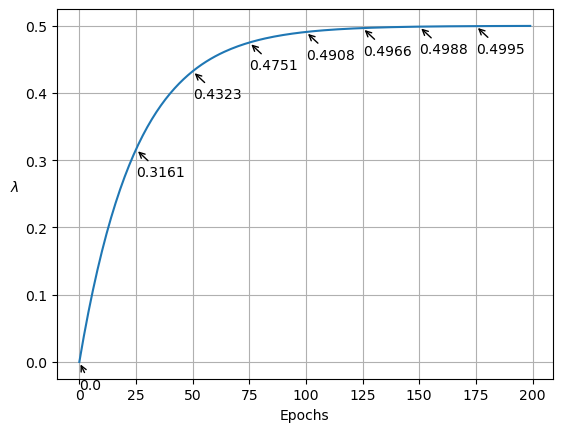

In [52]:
e = np.arange(0, 200, 1)
c_e = reg_coefficient(e, 0.5, 25)

fig, ax = plt.subplots()
ax.plot(e, c_e)
ax.set_xlabel('Epochs')
ax.set_ylabel('$\lambda$', rotation=0, ha='right')
ax.grid()

for i in range(0, 200, 25):
    ax.annotate(f"{round(c_e[i], 4)}", (i, c_e[i]), 
                xytext=(i+0.04, c_e[i]-0.04), arrowprops={'arrowstyle':'->'})

In [7]:
# return distances (dd) and indices (ii) of the 6 nearest neighbors to the point 0.06 (x), 0.42 (y)
dd, ii = tree.query([0.06, 0.42], k=6)

point = df['potential (V)'].iloc[ii[0]]
print(f'potential at point: {point}')

# get the mean of potential of the nearest neighbors
mean = df['potential (V)'].iloc[ii].mean()
print(f'mean around point: {mean}')

diff = np.abs(point-mean)
print(f'difference: {diff}')

potential at point: 51.5985
mean around point: 51.57316666666666
difference: 0.025333333333342978


## A different approach

This may work, but iterating over all points to evaluate the difference might be computationally expensive. Instead, it might be better to perform a filter operation over an image with SciPy. 

`scipy.ndimage.generic_filter` can compute a function over all values in an array, replacing the central value by the function output.

In [8]:
file2 = Path('/Users/jarl/2d-discharge-nn/data/interpolation_datasets/rec-interpolation2.nc')

### Open linearly interpolated dataset

In [9]:
ds = xr.open_dataset(file2)
ds

<xarray.Dataset>
Dimensions:        (y: 707, x: 200, P: 8, V: 4)
Coordinates:
  * y              (y) float64 0.0 0.001 0.002 0.003 ... 0.703 0.704 0.705 0.706
  * x              (x) float64 0.0 0.001 0.002 0.003 ... 0.196 0.197 0.198 0.199
  * P              (P) float64 5.0 10.0 30.0 45.0 60.0 80.0 100.0 120.0
  * V              (V) float64 200.0 300.0 400.0 500.0
Data variables:
    potential (V)  (V, P, y, x) float64 ...
    Ne (#/m^-3)    (V, P, y, x) float64 ...
    Ar+ (#/m^-3)   (V, P, y, x) float64 ...
    Nm (#/m^-3)    (V, P, y, x) float64 ...
    Te (eV)        (V, P, y, x) float64 ...

In [10]:
ds['potential (V)'].sel(V=200, P=100)

<xarray.DataArray 'potential (V)' (y: 707, x: 200)>
[141400 values with dtype=float64]
Coordinates:
  * y        (y) float64 0.0 0.001 0.002 0.003 0.004 ... 0.703 0.704 0.705 0.706
  * x        (x) float64 0.0 0.001 0.002 0.003 0.004 ... 0.196 0.197 0.198 0.199
    P        float64 100.0
    V        float64 200.0

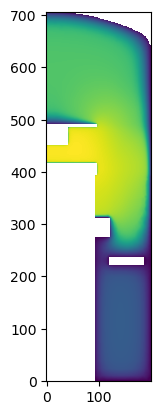

In [11]:
potential = ds['potential (V)'].sel(V=200, P=100).to_numpy()
plt.imshow(potential, origin='lower')

The footprint (`fp`) is a boolean array that specifies a shape, and selects which of the elements in the shape get passed to the filter function. Since we are taking the average of the surrounding pixels, it'll be a 3x3 array with a 0 at the center to exclude it.

In [12]:
fp = np.array([[1, 1, 1],
               [1, 0, 1],
               [1, 1, 1]])

In [13]:
from scipy.ndimage import generic_filter

potential_mean = generic_filter(potential, function=np.mean, footprint=fp)

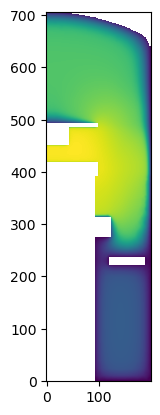

In [14]:
plt.imshow(potential_mean, origin='lower')

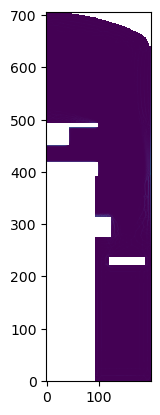

In [15]:
plt.imshow(np.abs(potential_mean - potential)*100, origin='lower')

In [16]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.nan_to_num(potential_mean), np.nan_to_num(potential))

2.82038333963053